In [2]:
import scvelo as scv
import scanpy as sc
import pandas as pd 
import numpy as np 
import os 
from pathlib import Path

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [4]:
notebook_dir = os.getcwd()
notebook_dir

'/Users/omercagatay/Desktop/Thesis/codes/notebooks'

In [5]:
Path(notebook_dir).parents[1]

PosixPath('/Users/omercagatay/Desktop/Thesis')

In [6]:
abs_path = str(Path(notebook_dir).parents[1])
os.chdir(abs_path)
os.getcwd()

'/Users/omercagatay/Desktop/Thesis'

# Adata

In [5]:
adata = scv.read("data/Xenium_V1_mouse_pup_outs/adata_location_filtered.h5ad")

In [13]:
adata

AnnData object with n_obs × n_vars = 39555 × 379
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'total_counts', 'cell_area', 'nucleus_area'
    var: 'gene_name', 'Ensemble ID', 'feature_types', 'genome'

# Transcripts

In [6]:
transcripts = pd.read_csv("data/Xenium_V1_mouse_pup_outs/transcripts_filtered.csv")

- remove transcripts which are not assigned to a cell

In [10]:
transcripts["cell_mapped"] = transcripts["cell_id"].apply(lambda x: "unassigned" if x == "UNASSIGNED" else "assigned")

In [21]:
# check proportion of transcripts assigned to a cell 
print(transcripts["cell_mapped"].value_counts())
print((transcripts["cell_mapped"].value_counts()[1]/len(transcripts))*100, "%")


cell_mapped
assigned      7989147
unassigned      38795
Name: count, dtype: int64
0.4832496298553228 %


In [15]:
tr = transcripts[transcripts["cell_id"] != "UNASSIGNED" ]
tr.reset_index(inplace=True, drop=True)
tr = tr.drop(columns=["Unnamed: 0"])

In [16]:
tr

,transcript_id,cell_id,overlaps_nucleus,feature_name,x_location,y_location,z_location,qv,fov_name,nucleus_distance,cell_mapped
0,282162171478024,cfbhgalg-1,0,Fxyd6,1927.0404,4950.6410,27.462738,36.826744,G4,14.152650,assigned
1,282162171478026,cfbhgalg-1,0,Sypl2,1930.1780,4960.1475,27.615625,40.000000,G4,13.390779,assigned
2,282162171478034,cfbhgalg-1,0,Anxa2,1939.3625,4963.5310,30.198410,36.826744,G4,11.156137,assigned
3,282162171478036,cfbhgalg-1,0,Fech,1939.6849,4946.4624,27.285930,40.000000,G4,4.113297,assigned
4,282162171478056,cfaiacmp-1,0,Cryab,1944.0469,4972.1743,26.068003,40.000000,G4,5.479392,assigned
...,...,...,...,...,...,...,...,...,...,...,...
7989142,282187942270866,amiiijhf-1,1,Krt19,5756.5327,5549.8228,26.122461,26.422700,H10,0.000000,assigned
7989143,282187942270897,amiiijhf-1,1,Krt19,5757.9770,5550.0537,21.278362,40.000000,H10,0.000000,assigned
7989144,282187942270904,amiibcmi-1,0,Krt19,5758.3780,5534.4660,23.390993,28.166980,H10,1.227634,assigned
7989145,282187942270950,amiiijhf-1,1,Krt19,5761.3994,5548.9434,25.935236,40.000000,H10,0.000000,assigned


In [30]:
adata.var[adata.var["gene_name"]=="Sypl2"]

,gene_name,Ensemble ID,feature_types,genome
339,Sypl2,ENSMUSG00000027887,Gene Expression,Unknown


In [17]:
# divide data in nuclei and cytopasm
tn = tr[tr['overlaps_nucleus'] == 1]
tc = tr[tr['overlaps_nucleus'] == 0]

# create the cellxgene matrix for nuc counts and cytoplasmic
nuc = pd.crosstab(tn['cell_id'],tn['feature_name'])
cyt = pd.crosstab(tc['cell_id'],tc['feature_name'])

In [51]:
adata = adata[adata.obs['cell_id'].isin(nuc.index)]

In [22]:
#get the cells which has a transcripts mappep to it 
adata = adata[adata.obs['cell_id'].isin(nuc.index)]
adata = adata[adata.obs['cell_id'].isin(cyt.index)]

# create "spliced", "unspliced" layers since scvelo looks for them
nucsort = nuc.loc[adata.obs['cell_id'],adata.var["gene_name"]]
cytsort = cyt.loc[adata.obs['cell_id'],adata.var["gene_name"]]

adata.layers['spliced'] = np.array(cytsort)
adata.layers['unspliced'] = np.array(nucsort)

In [23]:
adata

AnnData object with n_obs × n_vars = 39541 × 379
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'total_counts', 'cell_area', 'nucleus_area'
    var: 'gene_name', 'Ensemble ID', 'feature_types', 'genome'
    layers: 'spliced', 'unspliced'

In [24]:
adata.write("data/Xenium_V1_mouse_pup_outs/adata_filtered.h5ad")

In [4]:
data = adata.copy()
data

AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score'
    var: 'highly_variable_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

# Velocity 

- 3 options for calculating velocity:
    - Deterministic 
    - Dynamic
    - Stochastic 

Information can be found [here](https://scvelo.readthedocs.io/en/stable/about.html).

## Deterministic Velocity

In [7]:
adata = scv.read("data/Xenium_V1_mouse_pup_outs/adata_filtered.h5ad")

In [8]:
adata

AnnData object with n_obs × n_vars = 39541 × 379
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'total_counts', 'cell_area', 'nucleus_area'
    var: 'gene_name', 'Ensemble ID', 'feature_types', 'genome'
    layers: 'spliced', 'unspliced'

In [9]:
# filter, normalize 
sc.pp.filter_cells(adata,min_counts=20)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [10]:
# pca, neighbours, umap, leiden
sc.pp.pca(adata)
sc.pp.neighbors(adata,n_neighbors=30,n_pcs=0)
sc.tl.umap(adata,min_dist=0.05)
sc.tl.leiden(adata)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [11]:
adata

AnnData object with n_obs × n_vars = 39291 × 379
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_counts', 'leiden'
    var: 'gene_name', 'Ensemble ID', 'feature_types', 'genome'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

- Calculate Moments

In [12]:
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)

Normalized count data: spliced, unspliced.
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


- Calculate Velocity

In [13]:
scv.tl.velocity(adata, mode='deterministic')

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [15]:
adata

AnnData object with n_obs × n_vars = 39291 × 379
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_counts', 'leiden'
    var: 'gene_name', 'Ensemble ID', 'feature_types', 'genome', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'velocity_params'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu', 'velocity'
    obsp: 'distances', 'connectivities'

In [17]:
scv.tl.velocity_graph(adata)

computing velocity graph (using 1/8 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:28) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:05) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


/opt/anaconda3/envs/scvelo/lib/python3.12/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/anaconda3/envs/scvelo/lib/python3.12/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/anaconda3/envs/scvelo/lib/python3.12/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/anaconda3/envs/scvelo/lib/python3.12/site-packages/scvelo/plotting/utils.py:6

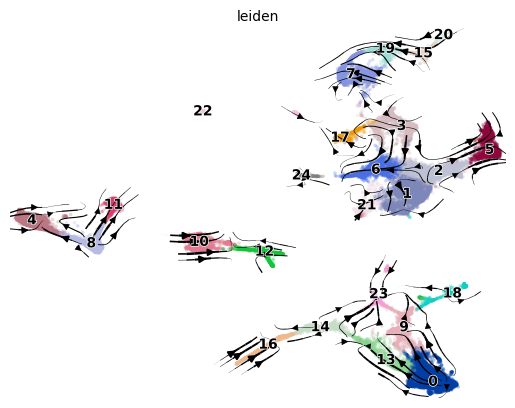

In [18]:
scv.pl.velocity_embedding_stream(adata, basis='umap',color='leiden')

In [19]:
adata.obsm["spatial"] = adata.obs[["x_centroid", "y_centroid"]].copy().to_numpy()

In [23]:
adata

AnnData object with n_obs × n_vars = 39291 × 379
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_counts', 'leiden', 'velocity_self_transition'
    var: 'gene_name', 'Ensemble ID', 'feature_types', 'genome', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'velocity_params', 'leiden_colors', 'velocity_graph', 'velocity_graph_neg'
    obsm: 'X_pca', 'X_umap', 'velocity_umap', 'spatial'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu', 'velocity'
    obsp: 'distances', 'connectivities'

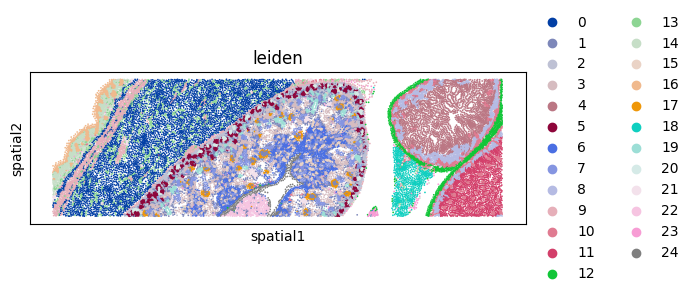

In [22]:
sc.pl.spatial(adata, color="leiden", spot_size = 15)

In [28]:
transition_matrix = scv.utils.get_transition_matrix(adata)

In [29]:
transition_matrix

<3696x3696 sparse matrix of type '<class 'numpy.float32'>'
	with 681987 stored elements in Compressed Sparse Row format>

## Dynamic Velocity 

In [36]:
adata = scv.read("data/Xenium_V1_mouse_pup_outs/adata_filtered.h5ad")

In [37]:
# filter, normalize 
sc.pp.filter_cells(adata,min_counts=20)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [38]:

# pca, neighbours, umap, leiden
sc.pp.pca(adata)
sc.pp.neighbors(adata,n_neighbors=30,n_pcs=30)
sc.tl.umap(adata,min_dist=0.05)
sc.tl.leiden(adata)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [39]:
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)

Normalized count data: spliced, unspliced.
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [40]:
scv.tl.recover_dynamics(adata)

recovering dynamics (using 1/8 cores)
    finished (0:30:33) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [41]:
scv.tl.velocity(adata, mode='dynamical')

computing velocities
    finished (0:00:08) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [42]:
scv.tl.velocity_graph(adata)

computing velocity graph (using 1/8 cores)
    finished (0:00:23) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


/opt/anaconda3/envs/scvelo/lib/python3.12/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/anaconda3/envs/scvelo/lib/python3.12/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/anaconda3/envs/scvelo/lib/python3.12/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/anaconda3/envs/scvelo/lib/python3.12/site-packages/scvelo/plotting/utils.py:6

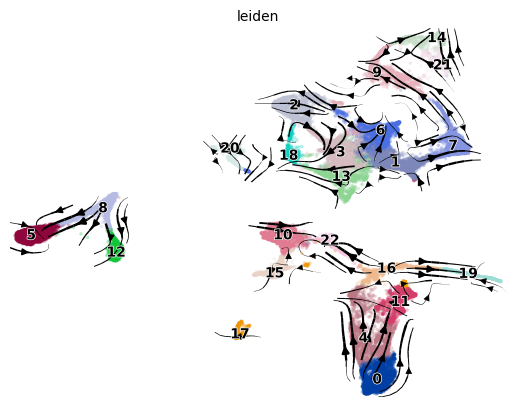

In [44]:
scv.pl.velocity_embedding_stream(adata, basis='umap',color="leiden")

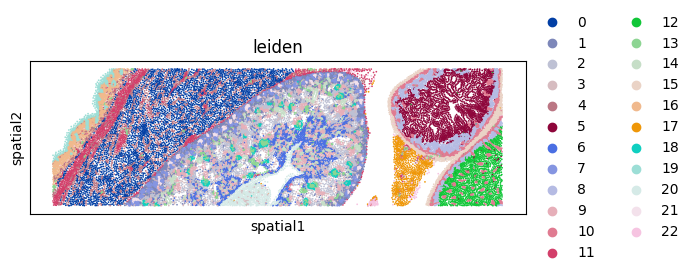

In [45]:
adata.obsm["spatial"] = adata.obs[["x_centroid", "y_centroid"]].copy().to_numpy()
sc.pl.spatial(adata, color="leiden", spot_size = 15)

In [46]:
adata.write("data/Xenium_V1_mouse_pup_outs/adata_filtered_dynamic.h5ad")

In [47]:
adata

AnnData object with n_obs × n_vars = 39291 × 379
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_counts', 'leiden', 'velocity_self_transition'
    var: 'gene_name', 'Ensemble ID', 'feature_types', 'genome', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'recover_dynamics', 'velocity_params', 'velocity_graph', 'velocity_graph_neg', 'leiden_colors'
    obsm: 'X_pca', 'X_umap', 'velocity_umap', 'spatial'
    varm: 'PCs', 'loss'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu', 'fit_t', 'fit_tau', 'fit_tau_', 'velocity', 'velocity_u'
    obsp: 'distances', 'connectivities'

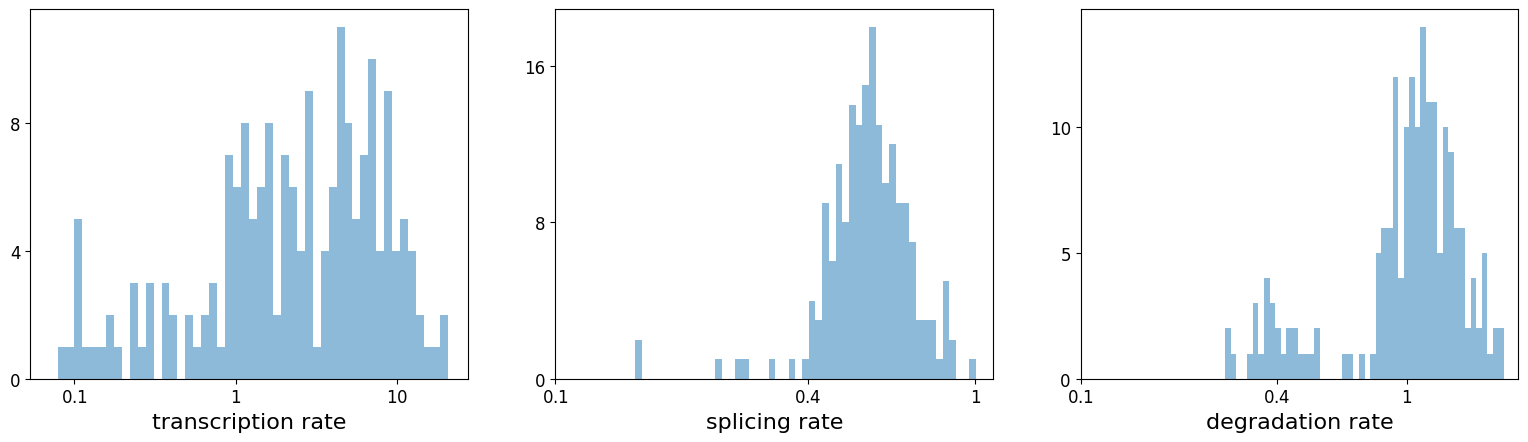

/var/folders/n1/3rys77050fl0ptsh50jc4t_40000gn/T/ipykernel_2343/3074921153.py:9: DeprecationWarning: `get_df` is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please `AnnData::get_df` or Scanpy's `scanpy.get.obs_df` or `scanpy.get.var_df`.
  scv.get_df(adata, 'fit*', dropna=True).head()


,fit_r2,fit_alpha,fit_beta,fit_gamma,fit_t_,fit_scaling,fit_std_u,fit_std_s,fit_likelihood,fit_u0,fit_s0,fit_pval_steady,fit_steady_u,fit_steady_s,fit_variance,fit_alignment_scaling
0,0.575385,0.112396,0.322276,0.395703,7.789025,1.814174,0.119005,0.077678,1.794359e-01,0.0,0.0,0.392269,0.359788,0.221242,1.315029,1.928931
2,0.715265,0.405616,1.265251,0.720712,3.773082,0.350789,0.098499,0.132675,3.104221e-01,0.0,0.0,0.292923,0.230714,0.272459,0.382785,1.032897
3,0.526545,0.474908,0.454523,0.391046,3.318019,2.702283,0.224934,0.141922,2.506094e-32,0.0,0.0,0.481683,1.023229,0.551857,1.185364,1.276205
4,0.644970,0.296406,0.762489,0.499205,7.405457,1.003752,0.129365,0.173668,2.252490e-01,0.0,0.0,0.412565,0.353487,0.516870,0.902432,1.592952
6,0.692437,0.192532,0.352494,0.427203,6.027383,1.926021,0.172434,0.126907,2.075628e-01,0.0,0.0,0.392151,0.475293,0.361893,0.856140,1.988480


In [48]:
df = adata.var
df = df[(df['fit_likelihood'] > .1) & df['velocity_genes'] == True]
kwargs = dict(xscale='log', fontsize=16)
with scv.GridSpec(ncols=3) as pl:
    pl.hist(df['fit_alpha'], xlabel='transcription rate', **kwargs)
    pl.hist(df['fit_beta'] * df['fit_scaling'], xlabel='splicing rate', xticks=[.1, .4, 1], **kwargs)
    pl.hist(df['fit_gamma'], xlabel='degradation rate', xticks=[.1, .4, 1], **kwargs)

scv.get_df(adata, 'fit*', dropna=True).head()

In [55]:
adata.var.iloc[[0,2,3,4,6]].gene_name

0    0610005C13Rik
2    2610528A11Rik
3    5330417C22Rik
4    6330403K07Rik
6         AU021092
Name: gene_name, dtype: object

### latent time 

computing terminal states
    identified 3 regions of root cells and 7 regions of end points .
    finished (0:00:05) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:07) --> added 
    'latent_time', shared time (adata.obs)


/opt/anaconda3/envs/scvelo/lib/python3.12/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/anaconda3/envs/scvelo/lib/python3.12/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/anaconda3/envs/scvelo/lib/python3.12/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/anaconda3/envs/scvelo/lib/python3.12/site-packages/scvelo/plotting/utils.py:6

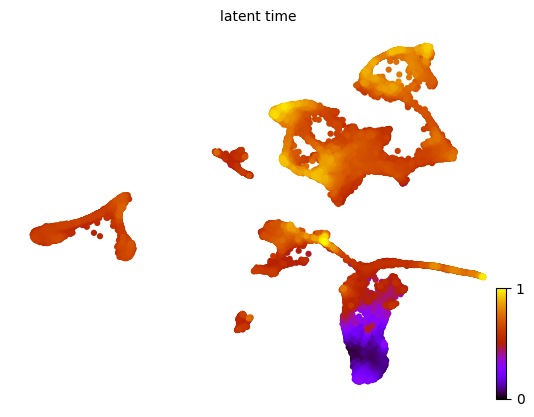

In [57]:
scv.tl.latent_time(adata)
scv.pl.scatter(adata, color='latent_time', color_map='gnuplot', size=80)

In [64]:
adata.var.set_index("gene_name",drop=True,inplace=True)

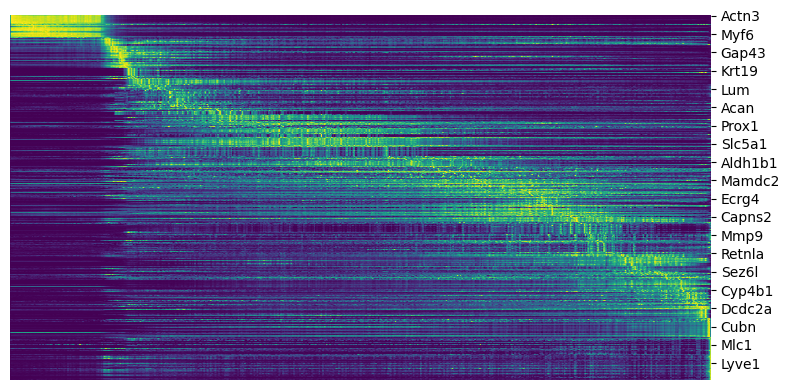

In [67]:
top_genes = adata.var['fit_likelihood'].sort_values(ascending=False).index
scv.pl.heatmap(adata, var_names=top_genes, sortby='latent_time',  n_convolve=100)

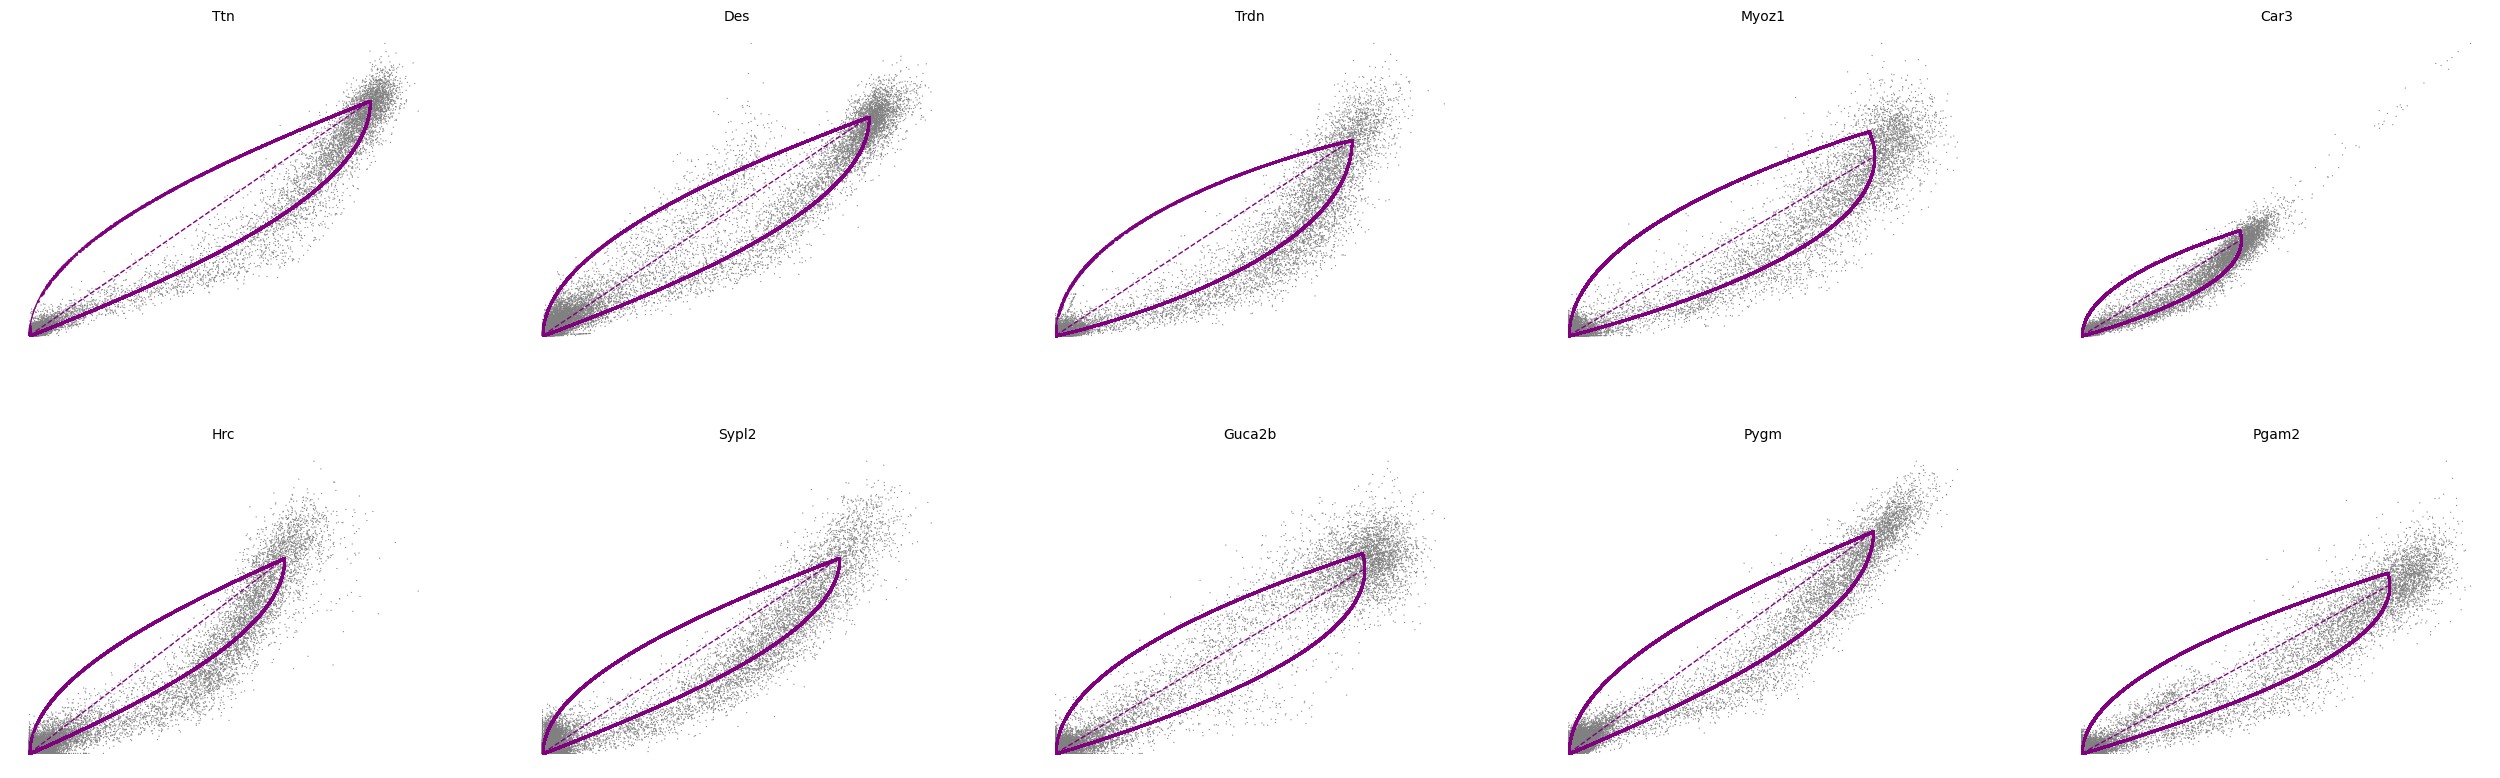

In [68]:
top_genes = adata.var['fit_likelihood'].sort_values(ascending=False).index
scv.pl.scatter(adata, basis=top_genes[:10], ncols=5, frameon=False)

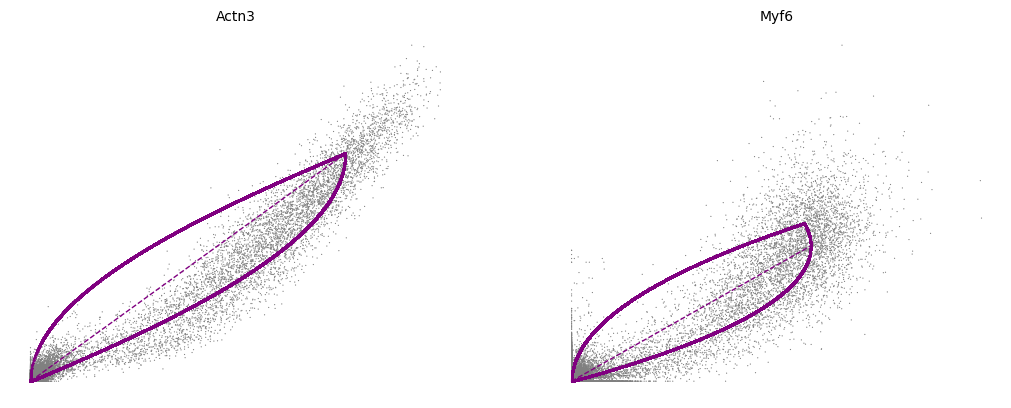

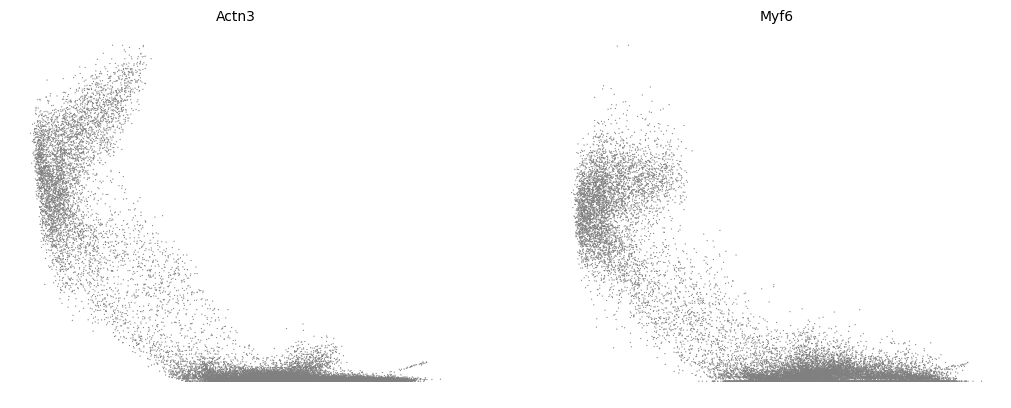

In [71]:
var_names = ['Actn3', 'Myf6']
scv.pl.scatter(adata, var_names, frameon=False)
scv.pl.scatter(adata, x='latent_time', y=var_names, frameon=False)

## Stochastic Velocity 

In [74]:
adata = scv.read("data/Xenium_V1_mouse_pup_outs/adata_filtered.h5ad")

In [75]:
# filter, normalize 
sc.pp.filter_cells(adata,min_counts=20)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
# pca, neighbours, umap, leiden
sc.pp.pca(adata)
sc.pp.neighbors(adata,n_neighbors=30,n_pcs=30)
sc.tl.umap(adata,min_dist=0.05)
sc.tl.leiden(adata)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [76]:
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)
scv.tl.velocity(adata, mode='stochastic')

Normalized count data: spliced, unspliced.
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities


/opt/anaconda3/envs/scvelo/lib/python3.12/site-packages/scvelo/tools/optimization.py:184: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[i] = np.linalg.pinv(A.T.dot(A)).dot(A.T.dot(y[:, i]))


    finished (0:00:03) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [77]:
scv.tl.velocity_graph(adata)

computing velocity graph (using 1/8 cores)
    finished (0:00:59) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


/opt/anaconda3/envs/scvelo/lib/python3.12/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/anaconda3/envs/scvelo/lib/python3.12/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/anaconda3/envs/scvelo/lib/python3.12/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/anaconda3/envs/scvelo/lib/python3.12/site-packages/scvelo/plotting/utils.py:6

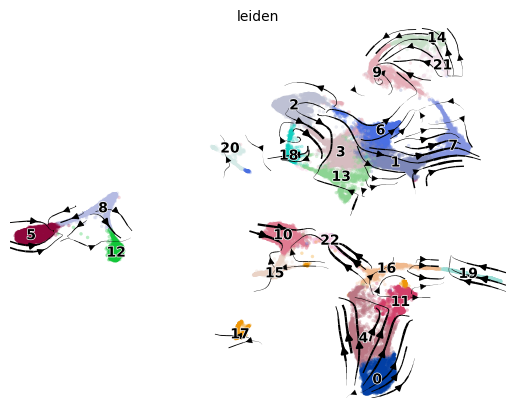

In [80]:
scv.pl.velocity_embedding_stream(adata, basis='umap', color="leiden")